In [2]:
import torch
import torchaudio
import torch.optim as optim
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model import Denoiser
from audio_dataset import Audio_Dataset
from trainer import Trainer
from loss import DenoiserLoss


In [2]:
config = {
    "device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "data_dir" : "data",
    "batch_size" : 10,
    "epochs" : 10,
    "learning_rate": 0.00005,
    "batches_per_epoch": 2268,
    "batches_per_epoch_val": 566,
    "train": 0.8,
    "val": 0.2,
}

In [3]:
train_dataset = Audio_Dataset(config, set_type="train")
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

val_dataset = Audio_Dataset(config, set_type="val")
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [4]:
trained_weights = 'model_final'

model = Denoiser(depth=5, N_attention=1)
model.load_state_dict(torch.load(trained_weights))
model.to(config["device"])
print(model)

loss_fn = DenoiserLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

Denoiser(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 48, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(48, 96, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (1): Sequential(
      (0): Conv1d(48, 96, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(96, 192, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (2): Sequential(
      (0): Conv1d(96, 192, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(192, 384, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (3): Sequential(
      (0): Conv1d(192, 384, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(384, 768, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
    (4): Sequential(
      (0): Conv1d(384, 768, kernel_size=(8,), stride=(4,))
      (1): ReLU()
      (2): Conv1d(768, 1536, kernel_size=(1,), stride=(1,))
      (3): GLU(dim=1)
    )
  )
  (attention): ModuleList(
    (0): Sequenti

In [5]:
summary(model)

Layer (type:depth-idx)                                       Param #
Denoiser                                                     --
├─ModuleList: 1-1                                            --
│    └─Sequential: 2-1                                       --
│    │    └─Conv1d: 3-1                                      432
│    │    └─ReLU: 3-2                                        --
│    │    └─Conv1d: 3-3                                      4,704
│    │    └─GLU: 3-4                                         --
│    └─Sequential: 2-2                                       --
│    │    └─Conv1d: 3-5                                      36,960
│    │    └─ReLU: 3-6                                        --
│    │    └─Conv1d: 3-7                                      18,624
│    │    └─GLU: 3-8                                         --
│    └─Sequential: 2-3                                       --
│    │    └─Conv1d: 3-9                                      147,648
│    │    └─ReLU: 

In [6]:
trainer = Trainer(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=config["epochs"],
    config=config,
    scheduler=scheduler,
)

model = trainer.train(train_dataloader,val_dataloader)

100%|██████████| 2269/2269 [07:39<00:00,  4.94it/s]


Training epoch complete


100%|██████████| 567/567 [01:35<00:00,  5.96it/s]


Eval epoch complete
Epoch: 1/10, Train Loss=0.1235463843, Val Loss=0.1208117666


100%|██████████| 2269/2269 [07:32<00:00,  5.01it/s]


Training epoch complete


100%|██████████| 567/567 [01:27<00:00,  6.48it/s]


Eval epoch complete
Epoch: 2/10, Train Loss=0.1262606382, Val Loss=0.1223944699


100%|██████████| 2269/2269 [07:10<00:00,  5.28it/s]


Training epoch complete


100%|██████████| 567/567 [01:34<00:00,  6.00it/s]


Eval epoch complete
Epoch: 3/10, Train Loss=0.1042443141, Val Loss=0.117073881


100%|██████████| 2269/2269 [07:35<00:00,  4.98it/s]


Training epoch complete


100%|██████████| 567/567 [01:33<00:00,  6.08it/s]


Eval epoch complete
Epoch: 4/10, Train Loss=0.1092616916, Val Loss=0.1165919084


100%|██████████| 2269/2269 [07:02<00:00,  5.37it/s]


Training epoch complete


100%|██████████| 567/567 [01:26<00:00,  6.56it/s]


Eval epoch complete
Epoch: 5/10, Train Loss=0.1049258709, Val Loss=0.1190746637


100%|██████████| 2269/2269 [06:50<00:00,  5.53it/s]


Training epoch complete


100%|██████████| 567/567 [01:26<00:00,  6.58it/s]


Eval epoch complete
Epoch: 6/10, Train Loss=0.1395872533, Val Loss=0.1186911179


100%|██████████| 2269/2269 [07:26<00:00,  5.09it/s]


Training epoch complete


100%|██████████| 567/567 [01:36<00:00,  5.87it/s]


Eval epoch complete
Epoch: 7/10, Train Loss=0.1522520483, Val Loss=0.1175128679


100%|██████████| 2269/2269 [07:08<00:00,  5.29it/s]


Training epoch complete


100%|██████████| 567/567 [01:30<00:00,  6.24it/s]


Eval epoch complete
Epoch: 8/10, Train Loss=0.1318825036, Val Loss=0.117721527


100%|██████████| 2269/2269 [07:02<00:00,  5.37it/s]


Training epoch complete


100%|██████████| 567/567 [01:28<00:00,  6.41it/s]


Eval epoch complete
Epoch: 9/10, Train Loss=0.1332807988, Val Loss=0.1166287713


100%|██████████| 2269/2269 [07:05<00:00,  5.33it/s]


Training epoch complete


100%|██████████| 567/567 [01:29<00:00,  6.33it/s]

Eval epoch complete
Epoch: 10/10, Train Loss=0.1231181026, Val Loss=0.115524312


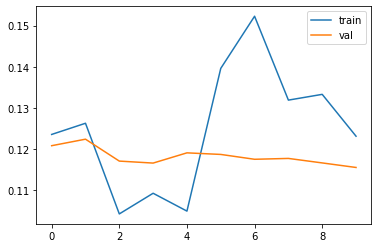

In [7]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

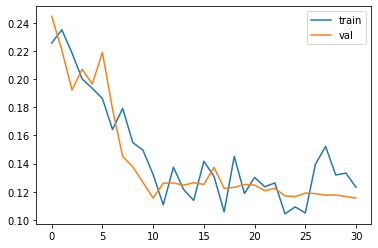

In [5]:
json_path = './trained_weights/valentini_515_attention/Loss.json'

f = open(json_path)
data = json.load(f)

plt.plot(data["train"], label="train")
plt.plot(data["val"], label="val")
plt.legend()
plt.show()

In [8]:
print(trainer.loss["train"])
print(trainer.loss["val"])

[0.12354638427495956, 0.1262606382369995, 0.10424431413412094, 0.10926169157028198, 0.10492587089538574, 0.13958725333213806, 0.15225204825401306, 0.13188250362873077, 0.13328079879283905, 0.12311810255050659]
[0.12081176660153391, 0.12239446994278587, 0.11707388099802024, 0.11659190841873276, 0.11907466365651899, 0.11869111791174247, 0.11751286789275561, 0.11772152698702282, 0.11662877132915736, 0.11552431203122702]


In [9]:
import json

json_obj = json.dumps(trainer.loss, indent=4)

with open("Loss.json", "a") as outfile:
    outfile.write(json_obj)